In [1]:
import numpy as np
print(np.__version__)


1.24.4


In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array


In [6]:
train_df = pd.read_csv("train_with_mapbox_images.csv")
train_df.shape


(16209, 22)

In [7]:
train_df.columns


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'image_path'],
      dtype='object')

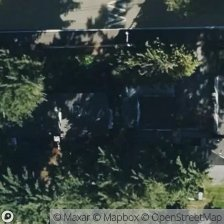

In [8]:
from PIL import Image
Image.open(train_df.loc[0, "image_path"])


In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(
    weights="imagenet",
    include_top=False,
    pooling="avg"   # gives 2048 features
)




In [12]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

img = Image.open(train_df.loc[0, "image_path"]).resize((224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

feat = model.predict(img)
feat.shape


1/1 [==============================] - 2s 2s/step


(1, 2048)

In [13]:
from tqdm import tqdm

image_features = []

for path in tqdm(train_df["image_path"]):
    img = Image.open(path).resize((224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    feat = model.predict(img, verbose=0)
    image_features.append(feat.squeeze())

image_features = np.array(image_features)
image_features.shape


100%|██████████████████████████████████████████████████████████████████████████| 16209/16209 [4:41:46<00:00,  1.04s/it]


(16209, 2048)

In [14]:
np.save("train_image_features.npy", image_features)
print("train_image_features.npy saved successfully")


train_image_features.npy saved successfully


## 5. Image Feature Extraction (Completed)

In this section, satellite images corresponding to each property were processed using a pretrained ResNet50 convolutional neural network.  
Each image was converted into a 2048-dimensional feature vector, capturing high-level spatial and visual characteristics such as built-up density, road connectivity, and surrounding environment.

The extracted image features are aligned row-wise with the tabular dataset and stored for further fusion and modeling.


## 6. Feature Fusion Preparation

In this section, tabular features and image-derived features are prepared for machine learning models.  
The goal is to compare model performance using:
1. Tabular features only  
2. Image features only  
3. A fused representation combining both modalities


In [19]:
X_tabular = train_df.drop(
    columns=["price", "image_path", "date"],
    errors="ignore"
)
y = train_df["price"]


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)


In [21]:
image_features = np.load("train_image_features.npy")


In [22]:
X_fused = np.hstack([X_tabular_scaled, image_features])


## TRAIN/VALIDATION SPLIT

In [23]:
from sklearn.model_selection import train_test_split

X_tab_tr, X_tab_val, y_tr, y_val = train_test_split(
    X_tabular_scaled, y, test_size=0.2, random_state=42
)

X_img_tr, X_img_val, _, _ = train_test_split(
    image_features, y, test_size=0.2, random_state=42
)

X_fus_tr, X_fus_val, _, _ = train_test_split(
    X_fused, y, test_size=0.2, random_state=42
)


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


lr = LinearRegression()
lr.fit(X_tab_tr, y_tr)

pred_lr = lr.predict(X_tab_val)

mae_lr = mean_absolute_error(y_val, pred_lr)
r2_lr = r2_score(y_val, pred_lr)

mae_lr, r2_lr


(125224.70229738261, 0.7076608073412656)

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_tab_tr, y_tr)

pred_rf = rf.predict(X_tab_val)

mae_rf = mean_absolute_error(y_val, pred_rf)
r2_rf = r2_score(y_val, pred_rf)

mae_rf, r2_rf


(71436.9409980326, 0.8662344879003878)

In [30]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_fus_tr, y_tr)

pred_xgb = xgb.predict(X_fus_val)

mae_xgb = mean_absolute_error(y_val, pred_xgb)
r2_xgb = r2_score(y_val, pred_xgb)

mae_xgb, r2_xgb


(72751.35960151913, 0.8703949285593672)

In [31]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost (Fused)"],
    "MAE": [mae_lr, mae_rf, mae_xgb],
    "R2 Score": [r2_lr, r2_rf, r2_xgb]
})

results


,Model,MAE,R2 Score
0,Linear Regression,125224.702297,0.707661
1,Random Forest,71436.940998,0.866234
2,XGBoost (Fused),72751.359602,0.870395


## Model Performance Comparison (MAE & R²)

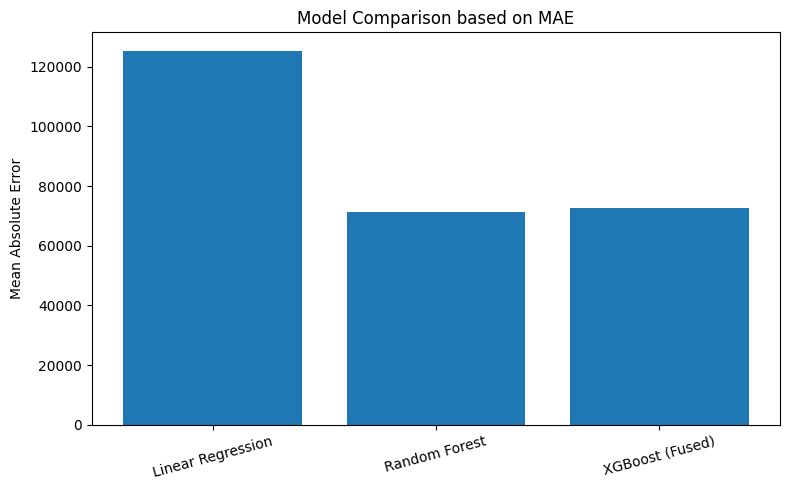

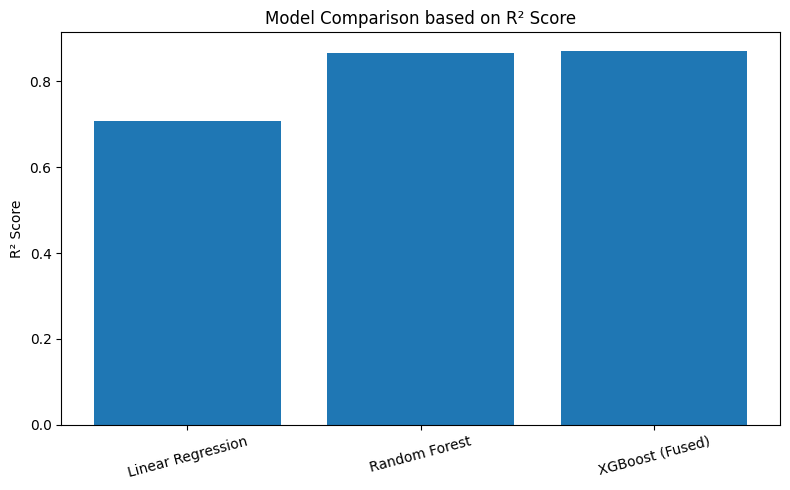

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost (Fused)"],
    "MAE": [mae_lr, mae_rf, mae_xgb],
    "R2 Score": [r2_lr, r2_rf, r2_xgb]
})

# MAE comparison
plt.figure(figsize=(8,5))
plt.bar(results["Model"], results["MAE"])
plt.title("Model Comparison based on MAE")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# R2 comparison
plt.figure(figsize=(8,5))
plt.bar(results["Model"], results["R2 Score"])
plt.title("Model Comparison based on R² Score")
plt.ylabel("R² Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Actual vs Predicted Prices (Best Model)

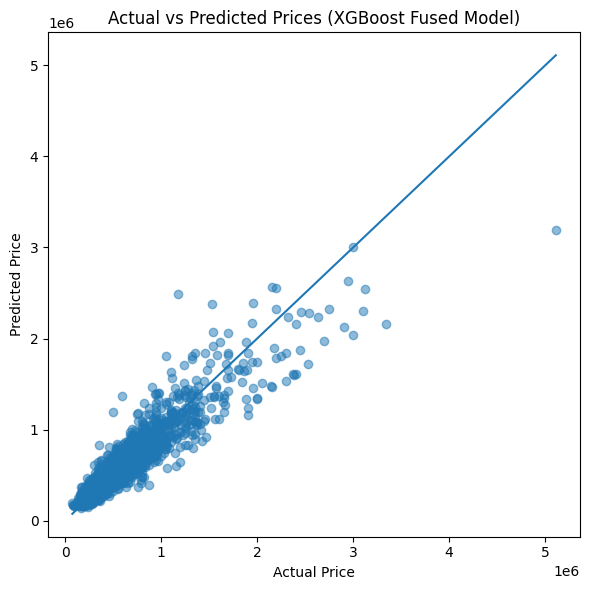

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, pred_xgb, alpha=0.5)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (XGBoost Fused Model)")
plt.tight_layout()
plt.show()


## Error Distribution (Residuals)

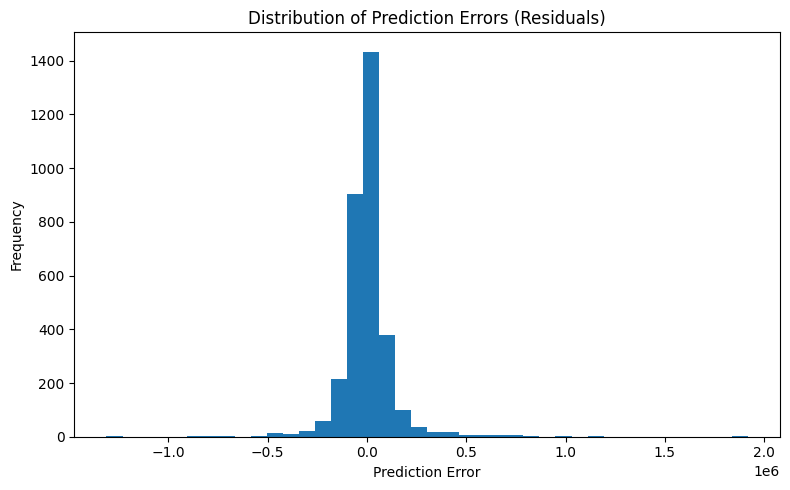

In [34]:
residuals = y_val - pred_xgb

plt.figure(figsize=(8,5))
plt.hist(residuals, bins=40)
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Feature Importance (XGBoost)

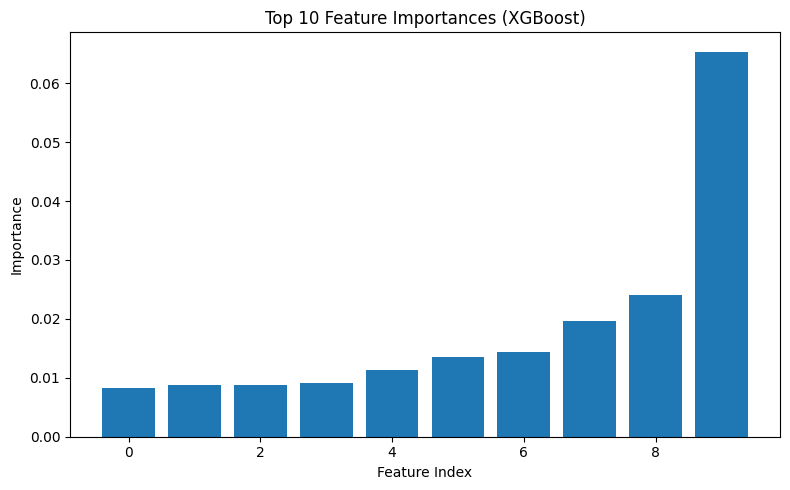

In [35]:
import numpy as np

importances = xgb.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(range(10), np.sort(importances)[-10:])
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [36]:
best_model = xgb
best_model_name = "XGBoost_Fused"

print("Final Model Selected:", best_model_name)
print("MAE:", mae_xgb)
print("R2 :", r2_xgb)


Final Model Selected: XGBoost_Fused
MAE: 72751.35960151913
R2 : 0.8703949285593672


In [37]:
import joblib

joblib.dump(best_model, "final_price_prediction_model.pkl")
print("Final model saved successfully")


Final model saved successfully


## FINAL STEP — TEST DATA → PREDICTION

In [38]:
import pandas as pd

test_df = pd.read_excel("test2.xlsx")
test_df.shape


(5404, 20)

In [39]:
X_test_tabular = test_df.drop(
    columns=["image_path", "date"],
    errors="ignore"
)


In [41]:
test_df["image_path"] = test_df.index.map(
    lambda x: f"mapbox_satellite_images/house_{x}.png"
)


In [43]:
test_df[["id", "image_path"]].head()


,id,image_path
0,2591820310,mapbox_satellite_images/house_0.png
1,7974200820,mapbox_satellite_images/house_1.png
2,7701450110,mapbox_satellite_images/house_2.png
3,9522300010,mapbox_satellite_images/house_3.png
4,9510861140,mapbox_satellite_images/house_4.png


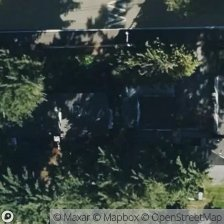

In [44]:
from PIL import Image
Image.open(test_df.loc[0, "image_path"])


In [45]:
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

test_image_features = []

for path in tqdm(test_df["image_path"]):
    img = Image.open(path).resize((224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    feat = model.predict(img, verbose=0)
    test_image_features.append(feat.squeeze())

test_image_features = np.array(test_image_features)
test_image_features.shape


100%|████████████████████████████████████████████████████████████████████████████| 5404/5404 [5:13:22<00:00,  3.48s/it]


(5404, 2048)

In [46]:
np.save("test_image_features.npy", test_image_features)
print("test_image_features saved")


test_image_features saved


In [47]:
test_image_features = np.load("test_image_features.npy")
test_image_features.shape


(5404, 2048)

In [48]:
X_test_tabular = test_df.drop(
    columns=["image_path", "date"],
    errors="ignore"
)


In [49]:
X_test_tabular_scaled = scaler.transform(X_test_tabular)


In [50]:
X_test_fused = np.hstack([
    X_test_tabular_scaled,
    test_image_features
])

X_test_fused.shape


(5404, 2067)

In [54]:
import joblib

final_model = joblib.load("final_price_prediction_model.pkl")
print("Final model loaded successfully")


Final model loaded successfully


In [55]:
test_predictions = final_model.predict(X_test_fused)
test_predictions[:10]


array([ 381601.62,  825925.1 , 1059216.2 , 2435685.8 ,  687321.75,
        286517.34,  767529.94,  684509.25,  416051.9 ,  566164.06],
      dtype=float32)

In [56]:
pd.DataFrame({
    "id": test_df["id"].head(10),
    "predicted_price": test_predictions[:10]
})


,id,predicted_price
0,2591820310,3.816016e+05
1,7974200820,8.259251e+05
2,7701450110,1.059216e+06
3,9522300010,2.435686e+06
4,9510861140,6.873218e+05
5,1761300310,2.865173e+05
6,7732410120,7.675299e+05
7,7010701383,6.845092e+05
8,291310170,4.160519e+05
9,4232901990,5.661641e+05


In [57]:
pd.Series(test_predictions).describe()


count    5.404000e+03
mean     5.475691e+05
std      3.519886e+05
min      1.020306e+05
25%      3.318382e+05
50%      4.624745e+05
75%      6.444847e+05
max      4.390776e+06
dtype: float64

In [58]:
import numpy as np

np.isnan(test_predictions).sum(), np.isinf(test_predictions).sum()


(0, 0)